In [42]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Dense ,Dropout,LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy

import seaborn as sns

In [2]:
tf.__version__

'2.1.0'

In [3]:
import tensorflow_datasets as tfds

# See all registered datasets
tfds.list_builders()




['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'gr

In [25]:
BUFFER_SIZE = 10000
BATCH_SIZE = 40
EMBED_DIM = 70
RNN_UNITS = 70


In [16]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

# Transform to dataset , shuffle and batch 
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes = ([None],[]))
# test data as well
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes = ([None],[]))


In [17]:
# allows encoding and decoding of text to integers
encoder = info.features['text'].encoder

In [18]:
VOCAB_SIZE = info.features['text'].vocab_size

In [19]:
# creating callback

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_latest")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [20]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    """
    Basic model build
    """
    i = Input(shape=(None,), batch_size=batch_size )
    x = Embedding(vocab_size, embedding_dim)(i)
    x = Bidirectional(LSTM(rnn_units))(x)
#    x = Dense(rnn_units*2, activation='relu')(x)
#    x = Dropout(0.5)(x)
    x = Dense(rnn_units, activation='relu')(x)
    x = Dense(1)(x)

    model = Model(i,x)
    
    return model

In [21]:
model = build_model(VOCAB_SIZE,EMBED_DIM,RNN_UNITS,BATCH_SIZE)

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(40, None)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (40, None, 100)           818500    
_________________________________________________________________
bidirectional_2 (Bidirection (40, 180)                 137520    
_________________________________________________________________
dense_4 (Dense)              (40, 90)                  16290     
_________________________________________________________________
dense_5 (Dense)              (40, 1)                   91        
Total params: 972,401
Trainable params: 972,401
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [13]:
history = model.fit(train_dataset, epochs=9,
                    validation_data=test_dataset, 
                    validation_steps=10,
                    callbacks=[checkpoint_callback]
                   )

Epoch 1/9
625/625 [==============================] - 58s 92ms/step - loss: 0.5783 - accuracy: 0.6252 - val_loss: 0.4450 - val_accuracy: 0.7450
Epoch 2/9
625/625 [==============================] - 55s 88ms/step - loss: 0.3037 - accuracy: 0.8742 - val_loss: 0.3963 - val_accuracy: 0.8000
Epoch 3/9
625/625 [==============================] - 55s 87ms/step - loss: 0.2305 - accuracy: 0.9118 - val_loss: 0.3806 - val_accuracy: 0.8200
Epoch 4/9
625/625 [==============================] - 55s 89ms/step - loss: 0.1993 - accuracy: 0.9270 - val_loss: 0.4291 - val_accuracy: 0.8375
Epoch 5/9
625/625 [==============================] - 55s 88ms/step - loss: 0.1717 - accuracy: 0.9376 - val_loss: 0.4434 - val_accuracy: 0.8475
Epoch 6/9
625/625 [==============================] - 55s 88ms/step - loss: 0.1551 - accuracy: 0.9447 - val_loss: 0.4865 - val_accuracy: 0.8325
Epoch 7/9
625/625 [==============================] - 55s 88ms/step - loss: 0.1328 - accuracy: 0.9546 - val_loss: 0.4736 - val_accuracy: 0.8500

In [26]:
# reload the model to return single predictions
model_reloaded = build_model(VOCAB_SIZE,EMBED_DIM,RNN_UNITS,1)  # set batch size to 1

# reload weights and rebuild
model_reloaded.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_reloaded.build(tf.TensorShape([1, None]))

In [27]:
model_reloaded.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(1, None)]               0         
_________________________________________________________________
embedding_4 (Embedding)      (1, None, 70)             572950    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 140)               78960     
_________________________________________________________________
dense_8 (Dense)              (None, 70)                9870      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 71        
Total params: 661,851
Trainable params: 661,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
def sample_predict(sample_pred_text):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model_reloaded.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)


In [29]:
sample_pred_text = 'The movie was great, amazing movie with good graphics'
sample_pred_text_bad = 'The movie was Horrible, Dont know what they were thinking'


In [30]:
sample_predict(sample_pred_text)


array([[1.2003284]], dtype=float32)

In [31]:
sample_predict(sample_pred_text_bad)

array([[-0.44350824]], dtype=float32)

In [38]:
history.history['loss']

[0.5783182617425918,
 0.30373056285381317,
 0.23045346764922142,
 0.19929612344503403,
 0.17173273286223412,
 0.1551150177448988,
 0.13281782451570034,
 0.12472599907666444,
 0.11610641037374735]

In [52]:
data = pd.DataFrame(history.history)

In [54]:
data.reset_index()

,index,loss,accuracy,val_loss,val_accuracy
0,0,0.578318,0.62516,0.444981,0.7450
1,1,0.303731,0.87420,0.396264,0.8000
2,2,0.230453,0.91184,0.380561,0.8200
3,3,0.199296,0.92696,0.429076,0.8375
4,4,0.171733,0.93760,0.443444,0.8475
5,5,0.155115,0.94468,0.486478,0.8325
6,6,0.132818,0.95460,0.473617,0.8500
7,7,0.124726,0.95676,0.509463,0.8500
8,8,0.116106,0.96080,0.503004,0.8525


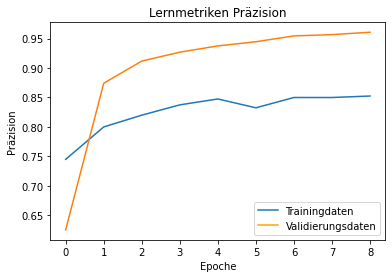

In [80]:
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(20,10))
f, ax = plt.subplots(1, 1)

ax = sns.lineplot(ax=ax,y = 'val_accuracy' , x='index',data=data.reset_index() )
ax = sns.lineplot(ax=ax ,y = 'accuracy' , x='index',data=data.reset_index() )

ax.set(xlabel='Epoche', ylabel='Präzision')
ax.set_title('Lernmetriken Präzision')

legend = ax.legend(labels=["Trainingdaten","Validierungsdaten"])
legend.legendHandles[1].set_color('orange')


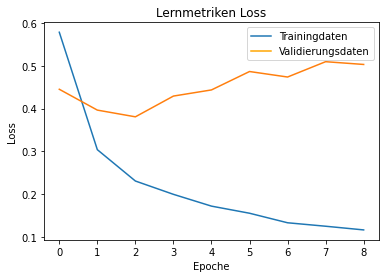

In [82]:


import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(20,10))
f, ax = plt.subplots(1, 1)

ax = sns.lineplot(y = 'loss' , x='index',data=data.reset_index() )
ax = sns.lineplot(y = 'val_loss' , x='index',data=data.reset_index() )
ax.set_title('Lernmetriken Loss')

ax.set(xlabel='Epoche', ylabel='Loss')

legend = ax.legend(labels=["Trainingdaten","Validierungsdaten"])
legend.legendHandles[1].set_color('orange')
